In [14]:
"""
Generalized Predictive Coding on Moving MNIST
"""

import matplotlib.pyplot as plt
import torch
import math
import numpy as np
import IPython
import MovingMNIST as MovingMNIST
from model_circles import *
from circles_dataset import *
import torchvision.transforms as transforms


In [15]:
# Load dataset and create model

IMG_SIZE = 16; BATCH_SIZE = 8; gen_coords = 2
train_set = MovingMNIST(root='.data/mnist', train=True, download=True,
                    transform=transforms.Compose([transforms.Scale(IMG_SIZE), transforms.ToTensor(),]))

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

net = GPC_net(b_size=BATCH_SIZE, dynamical_net=False, cause_sizes=[IMG_SIZE**2, 512, 256, 0],
              hidden_sizes=[0, 0, 0, 128], gen_coords=gen_coords, dt=1., length=9)

/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [16]:
# Training function
def run_model(epochs = 1, inference_steps=1, sequences=50, generate=False, dt=.1, BURN_IN=6):
    # logging
    if generate: results = []
    errors, cov_h, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3 = [[] for _ in range(8)]
    err_g1, err_g2, err_g3, cov_g1, cov_g2, cov_g3 = [[] for _ in range(6)]
    err_h1, err_h2, err_h3, l0, l1, l2, l3, l4, l5, l6 = [[] for _ in range(10)]

    for epoch in range(epochs):
        if epoch % 100 == 0: print("Epoch:", epoch)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=False)

        for seq_id, (seq, _) in enumerate(train_loader):

            # initialize hidden states
            if not generate:
                for layer in net.layers:
                    for d_layer in layer.dyn_model.layers:
                        torch.nn.init.constant(d_layer.states.hidd_state, 0)

            for repeat in range(5 if generate else 1): # train: single step, test: multistep
                if generate:
                    # state transition
                    net.layers[-1].dyn_model.forward_dynamical(apply=True, apply_encoding=True, dt=dt)
                else:
                    # update states and weights
                    for _ in range(inference_steps):

                        # feed cause
                        #net.generalized_feed(torch.transpose(seq, 0,1), time_to_batch=True, target=True)

                        # feed sensory data
                        net.generalized_feed(torch.transpose(seq, 0,1), time_to_batch=True) # todo improve

                        # step hierarchical
                        e, _, _, ch, _ = net.inference()

                        # step dynamical
                        eg1, eh1, ed1, cg1, cd1 = net.layers[-1].dyn_model.inference(predict_hierarchical=False)

                        # logging
                        errors, cov_h = errors + e, cov_h + ch
                        errors_d1, cov_d1 = errors_d1 + ed1, cov_d1 + cd1
                        err_g1, cov_g1, err_h1 = err_g1 + eg1, cov_g1 + cg1, err_h1+eh1

                # hierarchical posterior prediction
                pred = net.predict_from(start_layer=-1, overwrite=generate)

                 # collect prediction
                if generate:
                    results.append([p.copy() for p in pred])

            if seq_id == sequences:
                break

    # plot losses
    if not generate:
        plot_graph(errors, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3,cov_g1,
           cov_g2, cov_g3, err_g1, err_g2, err_g3, err_h1, err_h2, err_h3, cov_h, hierarchical=True, g_coords=False, dynamical=True)

    if not generate:
        return pred, seq
    else:
        return results

/var/folders/s2/6z2fgwwd73xf98ldhbjbxvp00000gn/T/ipykernel_20146/2329161785.py:19: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  torch.nn.init.constant(d_layer.states.hidd_state, 0)


Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900


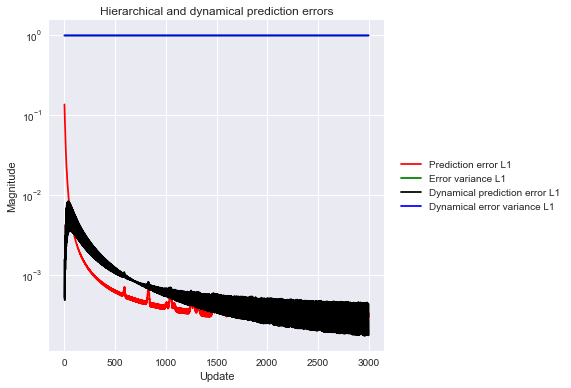

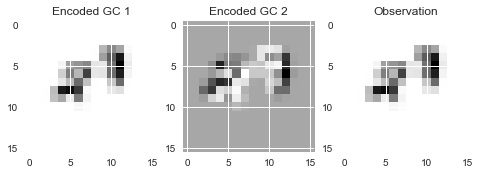

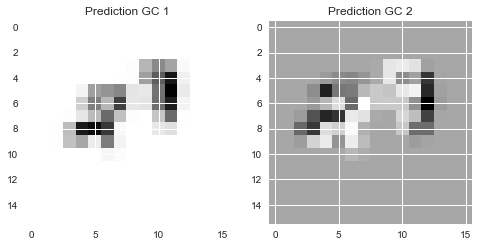

In [17]:
# Train model
pred, seq = run_model(epochs=1000, sequences=0, inference_steps=3, dt=1)

# Plot encoded and predicted sensory states
plot_sensory_coords(net, seq[0], IMG_SIZE=IMG_SIZE)
plot_2D_coords(pred, IMG_SIZE=IMG_SIZE)

Epoch: 0


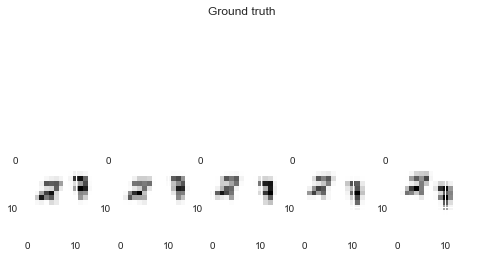

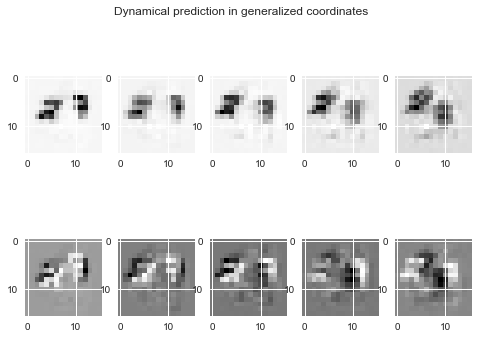

In [18]:
# Forward extrapolate model
results = run_model(epochs=1, sequences=0, inference_steps=0, generate=True, dt=1)
plot_2D_extrapolation(seq, np.asarray(results).transpose([1,0,2,3]), IMG_SIZE=IMG_SIZE)

Epoch: 0


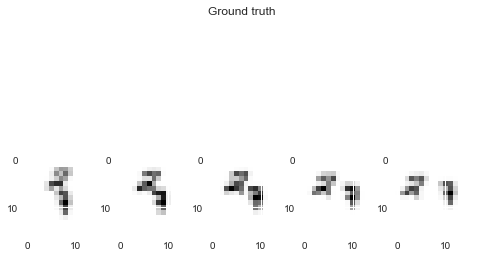

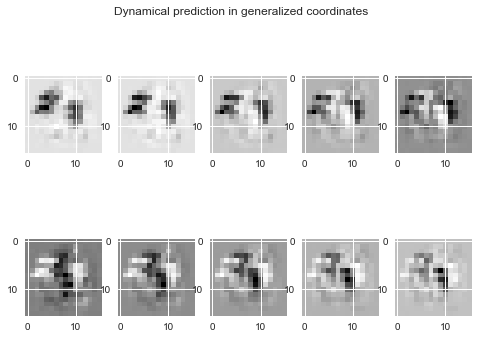

In [19]:
# Backward extrapolate model
results = run_model(epochs=1, sequences=0, inference_steps=0, generate=True, dt=-1)
plot_2D_extrapolation(seq.flip(1), np.asarray(results).transpose([1,0,2,3]), IMG_SIZE=IMG_SIZE)